This notebook is to establish the validity of the neural network I am using as a value and policy function approximator. I will train it on my training sets, using insample and out of sample evaluation.

The two datasets are of positions after 7 or 8 moves. Hence this is an easier task for the network than a general position, because in each case the 'player to move' channel of the input connect4 board will always be the same value for all boards in the datasets.

In [1]:
%matplotlib inline

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
np.random.seed(0)

In [2]:
n_epocs = 201
batch_size = 4096
test_size = 0.2
learning_rate = 0.05
momentum=0.9

# for you guys
PACKAGE_DIR = '{}/miniconda3/lib/python3.7/site-packages/oinkoink'.format(os.path.expanduser('~'))
# for me
PACKAGE_DIR = '{}/repo/connect4/oinkoink'.format(os.path.expanduser('~'))

In [3]:
from oinkoink.neural.pytorch.data import Connect4Dataset

dataset = Connect4Dataset.load(PACKAGE_DIR + '/data/connect4dataset_7ply.pth')

lengths = [int(np.ceil(test_size * len(dataset))), int(np.floor((1 - test_size) * len(dataset)))]
assert np.sum(lengths) == len(dataset)

train, test = data.random_split(dataset, lengths)

train_gen = data.DataLoader(train, batch_size, shuffle=True)
test_gen = data.DataLoader(train, batch_size, shuffle=False)

In [4]:
from oinkoink.neural.config import NetConfig
from oinkoink.neural.pytorch.model import Net

net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ResidualLayer(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
      )
      (1): ResidualLayer(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (ba

In [5]:
value_criterion = nn.MSELoss()
prior_criterion = nn.BCELoss()

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [6]:
from oinkoink.neural.stats import CombinedStats
from oinkoink.neural.pytorch.model import evaluate

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for epoch in range(1, n_epocs):
    net = net.train()
    
    train_stats = CombinedStats()
    
    for board, value, prior in train_gen:
        board, value, prior = board.to(device), value.to(device), prior.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        value_output, prior_output = net(board)
        assert value_output.shape == value.shape
        assert prior_output.shape == prior.shape
            
        value_loss = value_criterion(value_output, value)
        prior_loss = prior_criterion(prior_output, prior)
        loss = value_loss + prior_loss

        loss.backward()
        optimizer.step()
        
        train_stats.update(value_output.cpu().detach().numpy(),
                           value.cpu().numpy(),
                           value_loss,
                           prior_output.cpu().detach().numpy(),
                           prior.cpu().numpy(),
                           prior_loss)
    
    net.eval()
    test_stats = evaluate(test_gen, net, device, value_criterion, prior_criterion)
    
    train_df = train_df.append(train_stats.to_dict(), ignore_index=True)
    test_df = test_df.append(test_stats.to_dict(), ignore_index=True)

Text(0.5, 1.0, '7 ply positions')

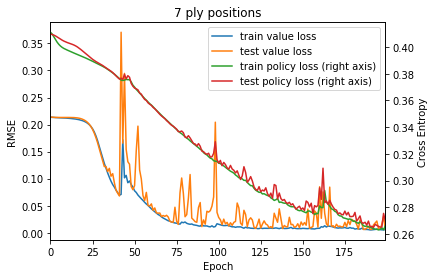

In [7]:
ax = train_df.plot(y='Average loss', legend=False)
test_df.plot(ax=ax, y='Average loss')
ax.set_ylabel('RMSE')
ax2 = train_df.plot(ax=ax, y='prior Average loss', secondary_y=True)
test_df.plot(ax=ax2, y='prior Average loss', secondary_y=True)
ax2.set_ylabel('Cross Entropy')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, ['train value loss', 'test value loss', 'train policy loss (right axis)', 'test policy loss (right axis)'], loc=0)

ax.set_xlabel('Epoch')
ax.set_title('7 ply positions')

Repeat all that with the 8 ply positions (which only have the value, no policy)

In [8]:
net = Net()
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [9]:
dataset = Connect4Dataset.load(PACKAGE_DIR + '/data/connect4dataset_8ply.pth')

lengths = [int(np.ceil(test_size * len(dataset))), int(np.floor((1 - test_size) * len(dataset)))]
assert np.sum(lengths) == len(dataset)

train, test = data.random_split(dataset, lengths)

train_gen = data.DataLoader(train, batch_size, shuffle=True)
test_gen = data.DataLoader(train, batch_size, shuffle=False)

In [10]:
from oinkoink.neural.stats import ValueStats
from oinkoink.neural.pytorch.model import evaluate_value_only

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for epoch in range(1, n_epocs):
    net = net.train()
    
    train_stats = ValueStats()
    
    for board, value in train_gen:
        board, value = board.to(device), value.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        value_output, prior_output = net(board)
        assert value_output.shape == value.shape

            
        loss = value_criterion(value_output, value)

        loss.backward()
        optimizer.step()
        
        train_stats.update(value_output.cpu().detach().numpy(),
                           value.cpu().numpy(),
                           loss)
    
    net.eval()
    test_stats = evaluate_value_only(test_gen, net, device, value_criterion)
    
    train_df = train_df.append(train_stats.to_dict(), ignore_index=True)
    test_df = test_df.append(test_stats.to_dict(), ignore_index=True)

Text(0.5, 1.0, '8 ply positions')

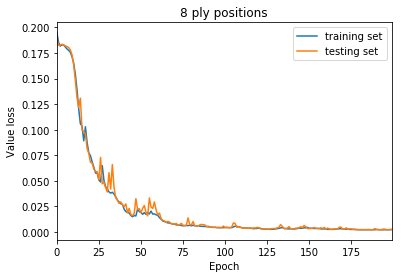

In [11]:
ax = train_df.plot(y='Average loss', legend=False)
test_df.plot(ax=ax, y='Average loss')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, ['training set', 'testing set'], loc=0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Value loss')
ax.set_title('8 ply positions')